In [1]:
from cmb.configs.experiments import Configs
from cmb.datasets.jetclass import JetsClassData

config = Configs('epic_hybrid.yaml') 
jets = JetsClassData(config.data)

INFO: created experiment instance beta-gauss_to_tops_ConditionalMarkovBridge_HybridEPiC_2024.09.27_02h02


## JetClass data

In [2]:
(jets.target.continuous.shape, 
jets.source.continuous.shape, 
jets.target.discrete.shape,
jets.source.discrete.shape,  
jets.target.mask.shape,
jets.source.mask.shape)

(torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 3]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]),
 torch.Size([100000, 128, 1]))

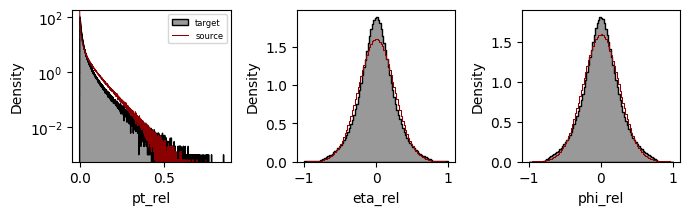

In [27]:
mask_target = (jets.target.mask > 0).squeeze() 
mask_source= (jets.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', mask=mask_target, ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', mask=mask_source, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('eta_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', mask=mask_target, binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', mask=mask_source, binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

(None, None)

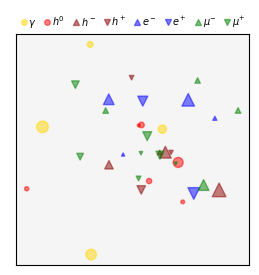

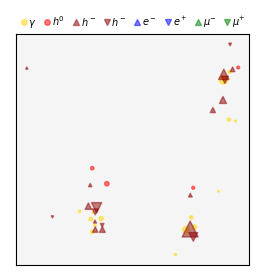

In [4]:
jets.source.display_cloud(idx=10,  scale_marker=200.0), jets.target.display_cloud(idx=10,  scale_marker=200.0)


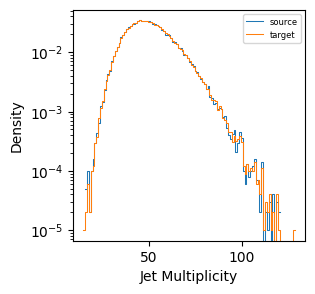

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [2]:
from cmb.models.trainers import GenerativeDynamicsModule
epic_cmb = GenerativeDynamicsModule(config, jets)
epic_cmb.train()

2024-09-27 02:02:23.596670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 02:02:23.634023: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 02:02:23.634507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 02:02:24.418549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: loading model...
  - model: HybridEPiC
  - dynamics: ConditionalMarkovBridge


INFO: number of training parameters: 506740
INFO: start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 90000, validation size: 10000, testing sizes: 0


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

### load trained model

In [ ]:
from cmb.models.trainers import GenerativeDynamicsModule

path='/home/df630/CMB/results/JetClass/beta-gauss_to_tops_BatchOTCFM_HybridEPiC_2024.09.26_02h23/config.yaml'
epic_cmb = GenerativeDynamicsModule(config=path)
epic_cmb.load()


2024-09-26 20:16:21.658013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 20:16:21.716636: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 20:16:21.717450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 20:16:23.253666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: loading model...
  - model: HybridEPiC
  - dynamics: ConditionalMarkovBridge
INFO: loading `best` epoch checkpoint from:
  - /home/df630/CMB/results/JetClass/beta-gauss_to_tops_BatchOTCFM_HybridEPiC_2024.09.26_02h23/best_epoch_model.pth


### Generate data

In [4]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.datasets.jetclass import JetsClassData
from cmb.datasets.jetclass import ParticleClouds

epic_cmb.config.data.source.test.num_jets = 2500

test = JetsClassData(epic_cmb.config.data, test=True)
epic_cmb.generate(source_continuous=test.source.continuous, 
                  source_discrete=torch.tensor(test.source.discrete),
                  mask=test.source.mask)

sample = torch.cat([epic_cmb.paths[-1], epic_cmb.jumps[-1].unsqueeze(-1)], dim=-1)
idx = torch.argsort(sample[...,0], dim=1, descending=True)
sample_pt_sorted = torch.gather(sample, 1, idx.unsqueeze(-1).expand(-1, -1, sample.size(2)))
sample = torch.cat([sample_pt_sorted, test.source.mask ], dim=-1)

sample = ParticleClouds(sample, min_num_particles=0, max_num_particles=128, discrete_features=True) 



/tmp/ipykernel_2441769/994743793.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_discrete=torch.tensor(test.source.discrete),


RuntimeError: Index tensor must have the same number of dimensions as input tensor

## Plot results

In [ ]:
args_sam = {'stat':'density', 'log_scale':(False, True), 'fill':False, 'color':'darkred', 'lw':0.75, 'label':'t=1'}
args_tar = {'stat':'density', 'log_scale':(False, True), 'fill':True, 'color':'k','lw':0.3, 'alpha':0.2, 'label':'target'}
args_src = {'stat':'density', 'log_scale':(False, True), 'fill':False, 'color':'darkblue','lw':0.75, 'label':'t=0'}

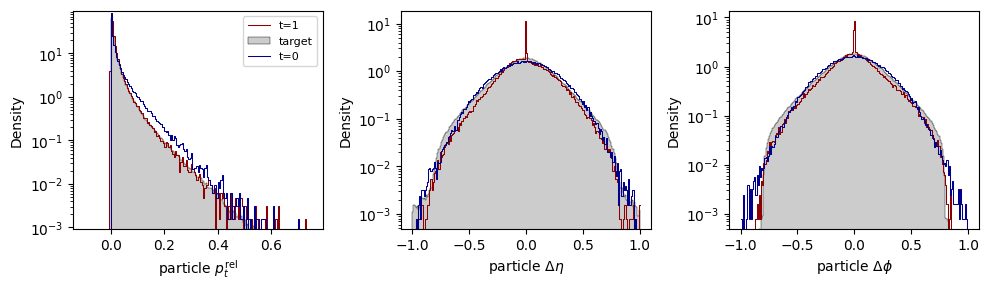

In [ ]:
mask_target = (test.target.mask > 0).squeeze() 
mask_source= (test.source.mask > 0).squeeze() 
mask_sample = (sample.mask > 0).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10,3))

sample.histplot('pt_rel', mask=mask_sample, binrange=(-.1, .75), binwidth=0.005, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.target.histplot('pt_rel', mask=mask_target,  binrange=(-.1, .75), binwidth=0.005, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)
test.source.histplot('pt_rel', mask=mask_source,  binrange=(-.1, .75), binwidth=0.005, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_src)

sample.histplot('eta_rel', mask=mask_sample, binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \eta$', ax=ax[1], **args_sam)
test.target.histplot('eta_rel', mask=mask_target,  binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_tar)
test.source.histplot('eta_rel', mask=mask_source, binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_src)

sample.histplot('phi_rel', mask=mask_sample, binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \phi$', ax=ax[2], **args_sam)
test.target.histplot('phi_rel', mask=mask_target,  binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_tar)
test.source.histplot('phi_rel', mask=mask_source, binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_distributions.png')
plt.show()

In [ ]:
test.target.continuous[:,0,:].shape

torch.Size([100000, 3])

IndexError: The shape of the mask [127149, 1] at index 0 does not match the shape of the indexed tensor [2500, 128] at index 0

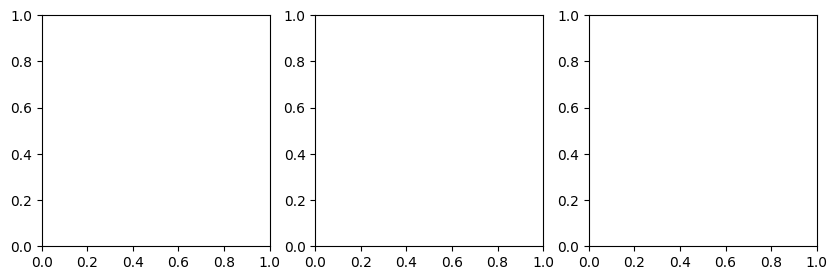

In [ ]:
N = 5

fig, ax = plt.subplots(1, 3, figsize=(10,3))

sample.histplot('pt_rel', mask=mask_sample, binrange=(-.1, 1), binwidth=0.01, xlabel=r'leading $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.target.histplot('pt_rel', mask=mask_target, binrange=(-.1, 1), binwidth=0.01, xlabel=r'leading $p_t^{\rm rel}$',ax=ax[0], **args_tar)
test.source.histplot('pt_rel', mask=mask_source, binrange=(-.1, 1), binwidth=0.01, xlabel=r'leading $p_t^{\rm rel}$',ax=ax[0], **args_src)

sample.histplot('eta_rel',  mask=mask_sample, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \eta$', ax=ax[1], **args_sam)
test.target.histplot('eta_rel',  mask=mask_target, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \eta$', ax=ax[1],  **args_tar)
test.source.histplot('eta_rel',  mask=mask_source, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \eta$', ax=ax[1],  **args_src)

sample.histplot('phi_rel',  mask=mask_sample, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \phi$', ax=ax[2], **args_sam)
test.target.histplot('phi_rel', mask=mask_target,  binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \phi$', ax=ax[2],  **args_tar)
test.source.histplot('phi_rel', mask=mask_source, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_leading_distributions.png')
plt.show()

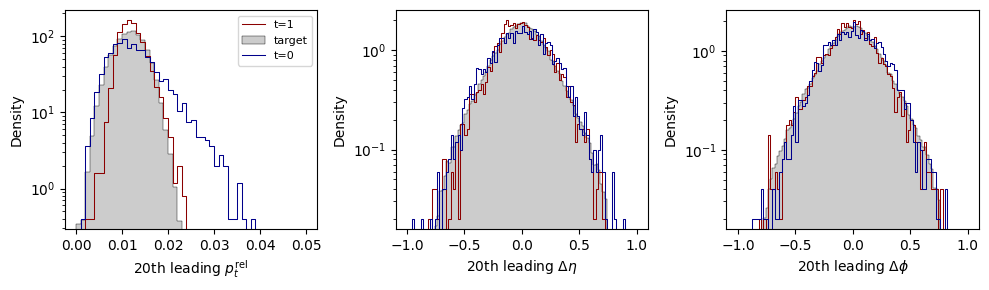

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(10,3))

sample.histplot('pt_rel', idx=20, binrange=(0, 0.05), binwidth=0.001, xlabel=r'20th leading $p_t^{\rm rel}$', ax=ax[0], **args_sam)
test.target.histplot('pt_rel', idx=20, binrange=(0, 0.05), binwidth=0.001, xlabel=r'20th leading $p_t^{\rm rel}$',ax=ax[0], **args_tar)
test.source.histplot('pt_rel', idx=20, binrange=(0, 1), binwidth=0.001, xlabel=r'20th leading $p_t^{\rm rel}$',ax=ax[0], **args_src)

sample.histplot('eta_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \eta$', ax=ax[1], **args_sam)
test.target.histplot('eta_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \eta$', ax=ax[1],  **args_tar)
test.source.histplot('eta_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \eta$', ax=ax[1],  **args_src)

sample.histplot('phi_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \phi$', ax=ax[2], **args_sam)
test.target.histplot('phi_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \phi$', ax=ax[2],  **args_tar)
test.source.histplot('phi_rel', idx=20, binrange=(-1, 1), binwidth=0.02, xlabel=r'20th leading $\Delta \phi$', ax=ax[2],  **args_src)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_subleading_distributions.png')
plt.show()

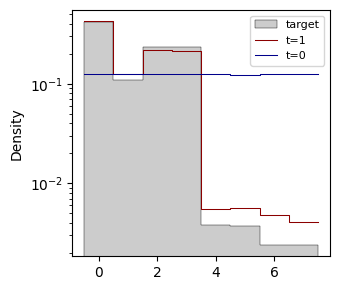

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(test.target.discrete[mask_target.squeeze(-1)], discrete=True, element='step', **args_tar)
sns.histplot(sample.discrete[mask_sample.squeeze(-1)], discrete=True, element='step', **args_sam)
sns.histplot(test.source.discrete[mask_source.squeeze(-1)], discrete=True, element='step', **args_src)
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()

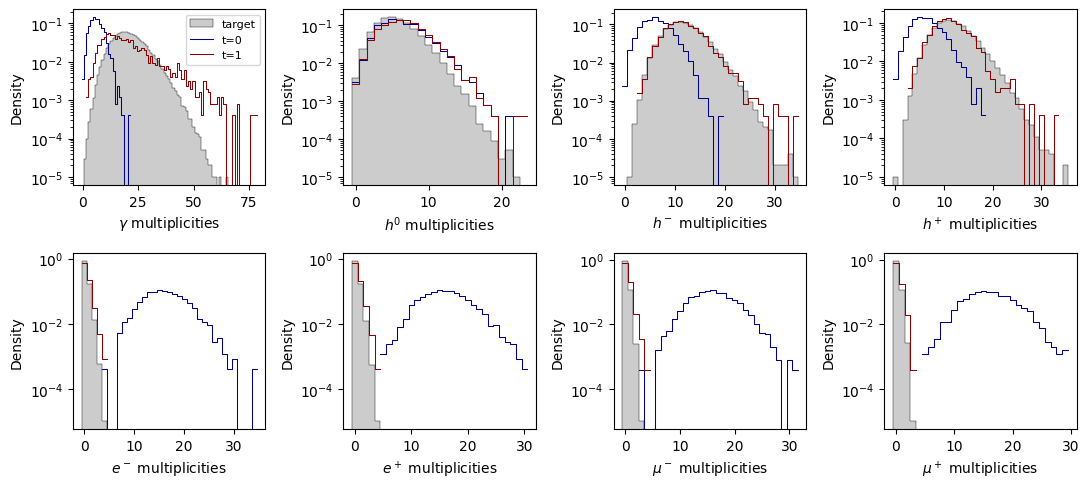

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(11,5))

dic = {0:r'$\gamma$', 1:r'$h^0$', 2:r'$h^-$', 3:r'$h^+$', 4:r'$e^-$', 5:r'$e^+$', 6:r'$\mu^-$', 7:r'$\mu^+$'}

for n in [0,1,2,3]:
    sample_counts = (sample.discrete == n) * mask_sample.squeeze(-1) 
    sample_counts = sample_counts.sum(dim=1)
    target_counts = (test.target.discrete == n) * mask_target.squeeze(-1)
    target_counts = target_counts.sum(dim=1)
    source_counts = (test.source.discrete == n) * mask_source.squeeze(-1)
    source_counts = source_counts.sum(dim=1)

    sns.histplot(target_counts, discrete=True, ax=ax[0,n], element='step', **args_tar)
    sns.histplot(source_counts, discrete=True, ax=ax[0,n], element='step', **args_src)
    sns.histplot(sample_counts, discrete=True, ax=ax[0,n], element='step', **args_sam)
    
    ax[0,n].set_xlabel(f'{dic[n]} multiplicities')
    
for n in [0,1,2,3]:
    sample_counts = (sample.discrete == 4+n).sum(dim=1)
    target_counts = (test.target.discrete == 4+n).sum(dim=1)
    source_counts = (test.source.discrete == 4+n).sum(dim=1)

    sns.histplot(target_counts, discrete=True, ax=ax[1,n], element='step', **args_tar)
    sns.histplot(source_counts, discrete=True, ax=ax[1,n], element='step', **args_src)
    sns.histplot(sample_counts, discrete=True, ax=ax[1,n], element='step', **args_sam)

    ax[1,n].set_xlabel(f'{dic[4+n]} multiplicities')

ax[0,0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()

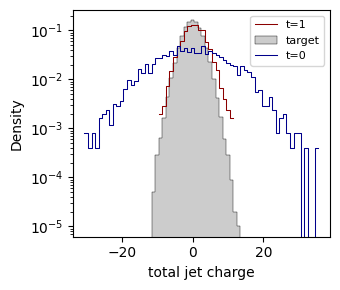

In [ ]:
sample_total_charge = (sample.discrete == 2).sum(dim=1) - (sample.discrete == 3).sum(dim=1) + (sample.discrete == 4).sum(dim=1) - (sample.discrete == 5).sum(dim=1) + (sample.discrete == 6).sum(dim=1) - (sample.discrete == 7).sum(dim=1)
target_total_charge = (test.target.discrete == 2).sum(dim=1) - (test.target.discrete == 3).sum(dim=1) + (test.target.discrete == 4).sum(dim=1) - (test.target.discrete == 5).sum(dim=1) + (test.target.discrete == 6).sum(dim=1) - (test.target.discrete == 7).sum(dim=1)
source_total_charge = (test.source.discrete == 2).sum(dim=1) - (test.source.discrete == 3).sum(dim=1) + (test.source.discrete == 4).sum(dim=1) - (test.source.discrete == 5).sum(dim=1) + (test.source.discrete == 6).sum(dim=1) - (test.source.discrete == 7).sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(sample_total_charge, discrete=True, element='step', **args_sam)
sns.histplot(target_total_charge, discrete=True, element='step', **args_tar)
sns.histplot(source_total_charge, discrete=True, element='step', **args_src)
ax.set_xlabel('total jet charge')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'total_jet_charge.png')
plt.show()


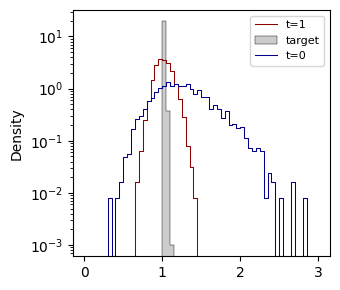

In [ ]:
sample_jet_pt = sample.continuous[...,0].sum(dim=1)
target_jet_pt = test.target.continuous[...,0].sum(dim=1)
source_jet_pt = test.source.continuous[...,0].sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(sample_jet_pt, binrange=(0., 3), binwidth=0.05, element='step', **args_sam)
sns.histplot(target_jet_pt, binrange=(0., 3), binwidth=0.05, element='step', **args_tar)
sns.histplot(source_jet_pt, binrange=(0., 3), binwidth=0.05, element='step', **args_src)
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_pt.png')
plt.show()